In [1]:
# plotting libraries
import matplotlib
import matplotlib.pyplot as plt 
# numpy (math) libary
import numpy as np

from os import walk

path1 = '../../../data/'

# torch library and sublibraries
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
f = [] # empty list of files
for (dirpath, dirnames, filenames) in walk(path1):
    f.extend(filenames)

# sort list alphabetically
f.sort()
# remove non .ssv files from list
f = [x for x in f if x[-4:]==".ssv"]

In [3]:
print(f[0])

temp = np.loadtxt(path1+f[0])
data = {}

data['x'] = np.copy(temp)[:,3:-1]
y = np.zeros((temp.shape[0], 11))
for jj in range(temp.shape[0]):
    y[jj, int(temp[jj,-1])] += 1
data['y'] = np.copy(y)
del y

print('input data x has shape: ',  data['x'].shape)
print('output data y has shape: ', data['y'].shape)
print()

if 0:
    jj = 6
    print(data['x'][jj,:])
    print(data['y'][jj,:])
    print(temp[jj,-1])

full_speach_data.ssv
input data x has shape:  (990, 10)
output data y has shape:  (990, 11)



In [4]:
# normalize data in the range [0,1]
for jj in range(data['x'].shape[1]):
    data['x'][:,jj] = (data['x'][:,jj]-min(data['x'][:,jj]))/max(data['x'][:,jj])

In [5]:
# divide training and test sets
train = {}
test = {}

# The problem is to train the network as well as possible using only
# on data from "speakers" 0-47, and then to test the network on
# speakers 48-89, reporting the number of correct classifications
# in the test set.

# setting '0'
default    = [48*11, 42*11]
# setting '1'

setting = 0
if setting == 0:
    train['x'] = np.copy(data['x'][:default[0],:])
    train['y'] = np.copy(data['y'][:default[0],:])
    
    test['x']  = np.copy(data['x'][-default[1]:,:])
    test['y']  = np.copy(data['y'][-default[1]:,:])
#elif setting == 1:
    
print(train['x'].shape)
print(train['y'].shape)
print()
print(test['x'].shape)
print(test['y'].shape)

(528, 10)
(528, 11)

(462, 10)
(462, 11)


In [6]:
# create x & y torch Variables
x = Variable( torch.from_numpy(train['x']).float() )
y = Variable( torch.from_numpy(train['y']).float() )
# either input data is float or model becomes doublefloat
# https://stackoverflow.com/questions/44717100/pytorch-convert-floattensor-into-doubletensor?rq=1
# create 
x_test = Variable( torch.from_numpy(test['x']).float() )
y_test = Variable( torch.from_numpy(test['y']).float() )

In [7]:
# define settings for plots
def show_graph(string):
    fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
    ax1 = fig.add_subplot(111)

    if string=='loglog':
        for ii, ee in models.items():
            ax1.loglog(ee[-1][:], label='%s, lr=%1.0e'%(ee[0][0],ee[5][0]))
    elif string=='logy':
        for ii, ee in models.items():
            ax1.semilogy(ee[-1][:], label='%s, lr=%1.0e'%(ee[0][0],ee[5][0]))
    elif string=='logx':
        for ii, ee in models.items():
            ax1.semilogy(ee[-1][:], label='%s, lr=%1.0e'%(ee[0][0],ee[5][0]))
    else:
        for ii, ee in err.items():
            ax1.plot(ee[-1][:], label='%s, lr=%1.0e'%(ee[0][0],ee[5][0]))

    ax1.set_xlabel('iteration number', fontsize = 16)
    ax1.set_ylabel('loss', fontsize = 16)
    title_string = '%d epochs, hidden layers [%d, %d] are width and depth'%(epochs, H, n)
    ax1.set_title(title_string, fontsize = 16)
    legend = ax1.legend(loc='best', fontsize=16)

    plt.show()
    plt.close()

# prints errors in semi-log axis
show_type = 'logy'

# some colors
colors = (('xkcd:orange', 'xkcd:red'),#
          ('xkcd:blue', 'xkcd:purple'),#
          ('xkcd:green', 'xkcd:lime'),#
         )

In [8]:
# define baseline network with relu (clamp)
class Baseline(torch.nn.Module):
    def __init__(self, D_in, H, D_out, n):
        super(Baseline, self).__init__()
        self.linear0 = torch.nn.Linear(D_in, H)
        for jj in range(n):
            exec("self.linear%d = torch.nn.Linear(H, H)" %(jj+1) );
        self.linearOut = torch.nn.Linear(H, D_out)

    def forward(self, x, n, NL_out=False):
        
        h = []
        # sum (linear1) and then relu (clamp)
        h.append( self.linear0(x).clamp(min=0) )
        # sum (linear2) and then relu (clamp)
        for jj in range(n):
            exec("h.append( self.linear%d(h[-1]).clamp(min=0) )" %(jj+1) );
        # sum (out) and the output
        if not NL_out:
            y_pred = self.linearOut(h[-1])
        elif NL_out:
            y_pred = self.linearOut(h[-1]).clamp(min=0)
        else:
            raise ValueError('NL_out must be either True or False, but it isn\'t')
        
        return y_pred # output = y_pred(icted)

In [9]:
# define different network with sigmoid
class BaseSigmoid(torch.nn.Module):
    def __init__(self, D_in, H, D_out, n):
        super(BaseSigmoid, self).__init__()
        self.linear0 = torch.nn.Linear(D_in, H)
        for jj in range(n):
            exec("self.linear%d = torch.nn.Linear(H, H)" %(jj+1) );
        self.linearOut = torch.nn.Linear(H, D_out)

    def forward(self, x, n, NL_out=False):
        h = []
        # sum (linear1) and then sigmoid (F.sigmoid)
        h.append( F.sigmoid(self.linear0(x)) )
        # sum (linear2) and then sigmoid (F.sigmoid)
        for jj in range(n):
            exec("h.append( F.sigmoid(self.linear%d(h[-1]) ) )" %(jj+1) );
        # sum (out) and the output
        if not NL_out :
            y_pred = self.linearOut(h[-1])
        elif NL_out :
            y_pred = F.sigmoid( self.linearOut(h[-1]) )
        else:
            raise ValueError('NL_out must be either True or False, but it isn\'t')
        
        return y_pred # output = y_pred(icted)

In [10]:
# define best fit class 
class BestFitSigmoid(torch.nn.Module):
    def __init__(self, D_in, H, D_out, n):
        super(BestFitSigmoid, self).__init__()
        self.linear0 = torch.nn.Linear(D_in, H)
        for jj in range(n):
            exec("self.linear%d = torch.nn.Linear(H, H)" %(jj+1) );
        self.linearOut = torch.nn.Linear(H, D_out)

    def forward(self, x, n, NL_out=False):
        
        # parameters
        p = [ 689.651615, 0.433819208, 1.31042204, -0.975437185, -0.518489780, 0.403015568, 0.502495627]
        
        #p[0], p[1], p[2], p[3], p[4], p[5], p[6]
        #  a,    b,    c,    d,    g,   x0,   x1)
        #b*sigmoid(a*(arg-x0))+c*relu(arg)+d*relu(arg-x0)+g*relu(arg-x1)
        
        h = []
        h.append( torch.mul( torch.sigmoid( self.linear0(x).add_(-p[5]).mul_(p[0]) ), p[1] ) )
        h[0].add_( self.linear0(x).clamp(min=0).mul_(p[2]) )
        h[0].add_( self.linear0(x).clamp(min=p[5]).mul_(p[3]) )
        h[0].add_( self.linear0(x).clamp(min=p[6]).mul_(p[4]) )
        
        # sum (linear2) and then nonlinear function
        for jj in range(n):
            exec("h.append( torch.mul( torch.sigmoid( self.linear%d(h[-1]).add_(-p[5]).mul_(p[0]) ), p[1] ) )" %(jj+1) );
            exec("h[jj+1].add_( self.linear%d(h[-2]).clamp(min=0).mul_(p[2]) )" %(jj+1) );
            exec("h[jj+1].add_( self.linear%d(h[-2]).clamp(min=p[5]).mul_(p[3]) )" %(jj+1) );
            exec("h[jj+1].add_( self.linear%d(h[-2]).clamp(min=p[6]).mul_(p[4]) )" %(jj+1) );
                     
        # sum (out) and the output
        if not NL_out :
            y_pred = self.linearOut(h[-1])
        elif NL_out:
            y_pred = torch.mul( torch.sigmoid( self.linearOut(h[-1]).add_(-p[5]).mul_(p[0]) ), p[1] )
            y_pred.add_( self.linearOut(h[-1]).clamp(min=0).mul_(p[2]) )
            y_pred.add_( self.linearOut(h[-1]).clamp(min=p[5]).mul_(p[3]) )
            y_pred.add_( self.linearOut(h[-1]).clamp(min=p[6]).mul_(p[4]) )
        else:
            raise ValueError('NL_out must be either True or False, but it isn\'t')
                                
        return y_pred # output = y_pred(icted)

In [11]:
def generate_entry(ii, verbose = False):
    global models
    global LL
                     
    models[ii] = [LL[ii][0],]
    # append model
    if LL[ii][1]=='base':
        models[ii].append( Baseline(D_in, models[ii][0][1], D_out, models[ii][0][2]) )
    elif LL[ii][1]=='sigmoid':
        models[ii].append( BaseSigmoid(D_in, models[ii][0][1], D_out, models[ii][0][2]) )
    elif LL[ii][1]=='bestfit':
        models[ii].append( BestFitSigmoid(D_in, models[ii][0][1], D_out, models[ii][0][2]) )
    else:
        raise ValueError('model type not recognised')
    if verbose:
        print('model:', models[ii][1])
        print('model settings:',D_in, D_out, models[ii][0][1], models[ii][0][2], models[ii][0][3])
    
    # append criterion
    if LL[ii][2]=='MSE':
        models[ii].append( torch.nn.MSELoss(size_average=False ) )
        models[ii].append( LL[ii][3] )
    #elif ll[2]=='':
    else:
        raise ValueError('criterion type not recognised')
        
    if verbose:
        print('criterion:', models[ii][2], '\ncriterion settings:', models[ii][3])
    
    # append optimizer
    if LL[ii][4]=='SGD':
        models[ii].append( torch.optim.SGD(models[ii][1].parameters(), lr=LL[ii][5][0]) )
        models[ii].append( LL[ii][5] )
    #elif ll[4]=='':
    else:
        raise ValueError('optimizer type not recognised')
    
    if verbose:
        print('optimizer:', models[ii][4], '\noptimizer settings:\n', models[ii][5])
    
    # append empty errors list
    models[ii].append( [] )
    print()

def run_training(ii):
    global models
    global x, y
                
    for t in range(models[ii][0][4]):
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = models[ii][1](x, models[ii][0][2], models[ii][0][3])

        # Compute and print loss
        loss = models[ii][2](y_pred, y)
        models[ii][-1].append(loss.data[0])
        if (t+1)%(epochs//20) == 0:
            print(t+1, loss.data[0])

        # Zero gradients, perform a backward pass, and update the weights.
        models[ii][4].zero_grad()
        loss.backward()
        models[ii][4].step()

def run_test(ii, verbose=True):
    global models
    global x_test, y_test
                     
    y_pred = models[ii][1](x, models[ii][0][2], models[ii][0][3])
    
    correctness = 0
    for jj in range(x_test.shape[0]):
        if y_test.data[jj, np.argmax(y_pred.data[jj,:]) ]:
            correctness += 1
    correctness = correctness/x_test.shape[0]*100
    
    if verbose:
        print('%3.2f'%correctness)

In [12]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N     = train['x'].shape[0]
D_in  = train['x'].shape[1]
H     = 64
D_out = train['y'].shape[1]
n     = 1

epochs = int(5e2)

In [13]:
# model settings
base_lr = 1e-4
sigm_lr = 1e-6
best_lr = 1e-5

In [14]:
# settings: '' name, H = width of hidden layers, n = number of hidden H-layers,
#           NL_out = nonlinear output layer/sum-only output layer,
#           'model'
#           'criterion' and parameters
#           'optimizer' and parameters
LL = [[['relu baseline', H, 1, False, epochs],
       'base',
       'MSE', [False],
       'SGD', [base_lr]
      ],
      [['base sigmoid', H, 1, False, epochs],
       'sigmoid',
       'MSE', [False],
       'SGD', [sigm_lr]
      ],
      [['bestfit', H, 1, False, epochs],
       'bestfit',
       'MSE', [False],
       'SGD', [best_lr]
      ],
     ]
print(len(LL))

models = {}

3


model: Baseline(
  (linear0): Linear(in_features=10, out_features=64)
  (linear1): Linear(in_features=64, out_features=64)
  (linearOut): Linear(in_features=64, out_features=11)
)
model settings: 10 11 64 1 False
criterion: MSELoss(
) 
criterion settings: [False]
optimizer: <torch.optim.sgd.SGD object at 0x7f2c88ef2c88> 
optimizer settings:
 [0.0001]

25 450.8414611816406
50 430.45379638671875
75 415.37646484375
100 402.1302490234375
125 391.2021789550781
150 382.18682861328125
175 374.6331787109375
200 367.8070373535156
225 361.383544921875
250 355.1804504394531
275 349.19891357421875
300 343.5318908691406
325 338.096923828125
350 332.93988037109375
375 328.4501647949219
400 324.72918701171875
425 320.206787109375
450 315.11126708984375
475 310.9408874511719
500 307.0849609375


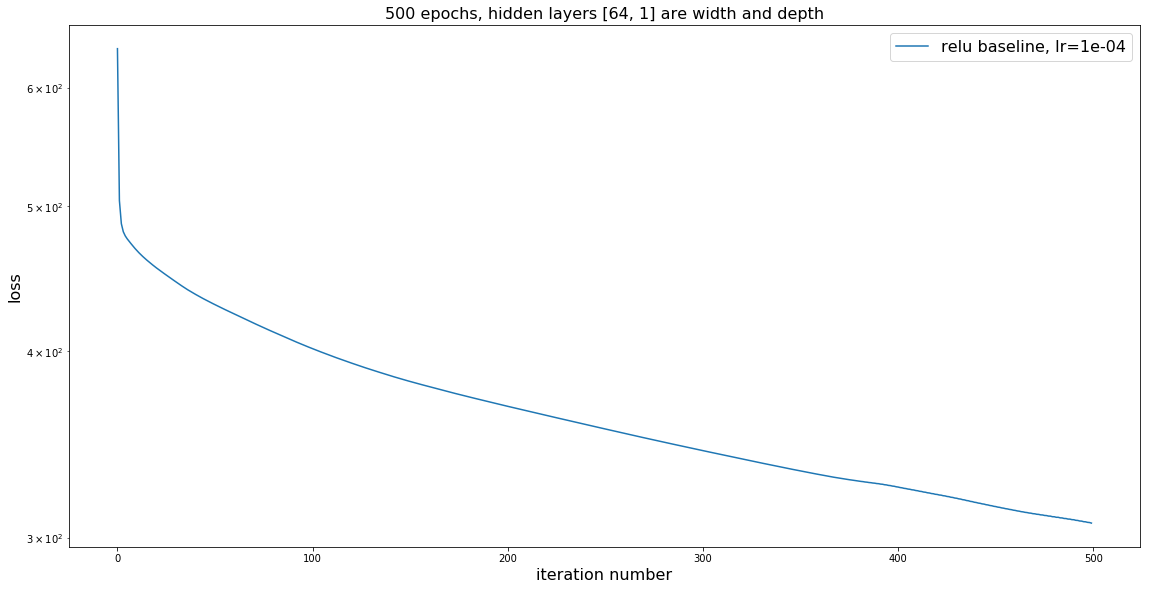

71.43


In [15]:
generate_entry(0, True)
run_training(0)
show_graph(show_type)
run_test(0)

model: BaseSigmoid(
  (linear0): Linear(in_features=10, out_features=64)
  (linear1): Linear(in_features=64, out_features=64)
  (linearOut): Linear(in_features=64, out_features=11)
)
model settings: 10 11 64 1 False
criterion: MSELoss(
) 
criterion settings: [False]
optimizer: <torch.optim.sgd.SGD object at 0x7f2c88ec5e48> 
optimizer settings:
 [1e-06]

25 545.50390625
50 504.7318420410156
75 489.3810119628906
100 483.595458984375
125 481.41265869140625
150 480.5839538574219
175 480.2676086425781
200 480.14324951171875
225 480.0911865234375
250 480.06634521484375
275 480.0523376464844
300 480.04156494140625
325 480.0318908691406
350 480.0235900878906
375 480.015625
400 480.0082702636719
425 479.9989013671875
450 479.9899597167969
475 479.9817810058594
500 479.97308349609375


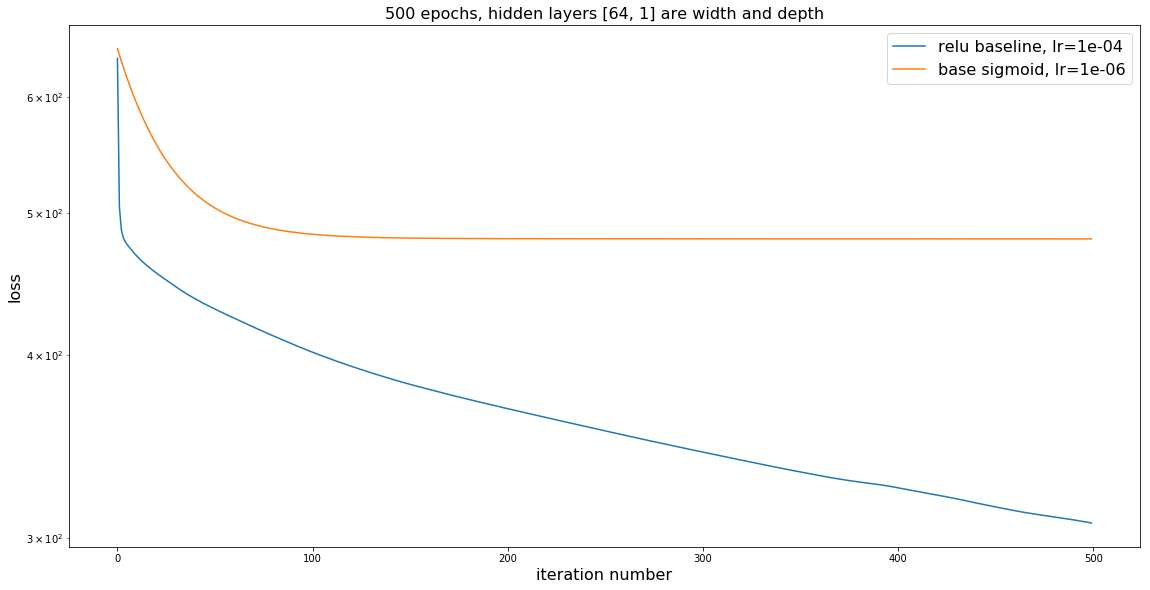

11.04


In [16]:
generate_entry(1, True)
run_training(1)
show_graph(show_type)
run_test(1)

model: BestFitSigmoid(
  (linear0): Linear(in_features=10, out_features=64)
  (linear1): Linear(in_features=64, out_features=64)
  (linearOut): Linear(in_features=64, out_features=11)
)
model settings: 10 11 64 1 False
criterion: MSELoss(
) 
criterion settings: [False]
optimizer: <torch.optim.sgd.SGD object at 0x7f2c88634860> 
optimizer settings:
 [1e-05]

25 473.24371337890625
50 452.68145751953125
75 439.1056213378906
100 425.5675048828125
125 416.9935302734375
150 409.1769104003906
175 402.7119445800781
200 397.6768798828125
225 391.7657165527344
250 387.543701171875
275 382.9645080566406
300 378.7288818359375
325 375.42266845703125
350 372.4184265136719
375 368.33306884765625
400 365.5027770996094
425 362.3975830078125
450 358.4203186035156
475 356.371337890625
500 353.38995361328125


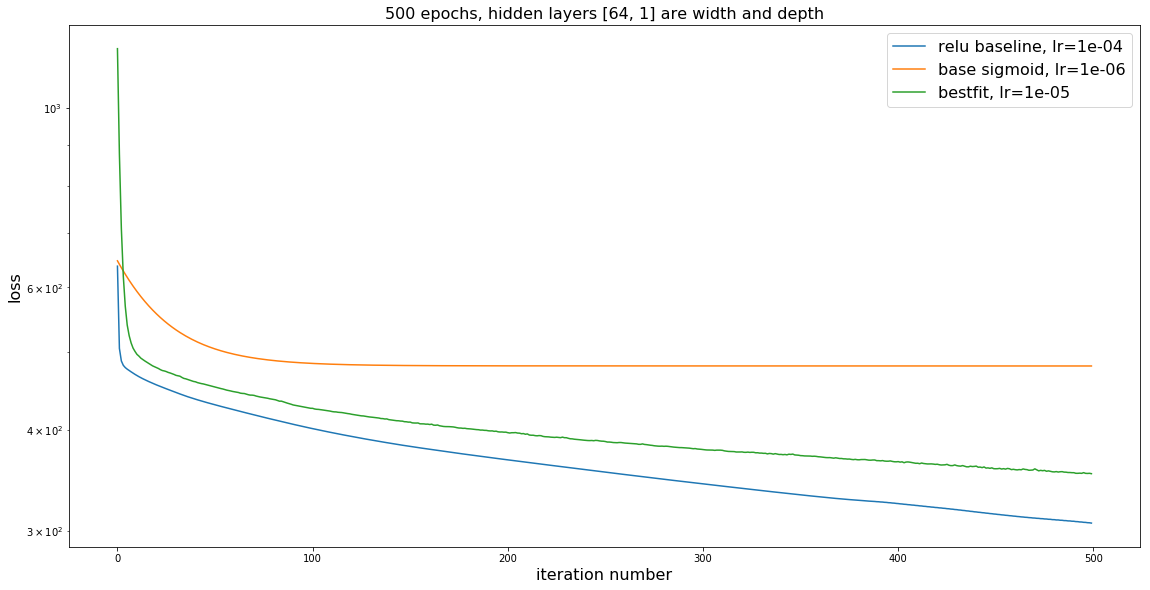

69.91


In [17]:
generate_entry(2, True)
run_training(2)
show_graph(show_type)
run_test(2)